<a href="https://colab.research.google.com/github/amitadhainje/LearningBERT/blob/master/Bert_Using_Pytorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q -U watermark

In [5]:
!pip install -qq transformers

In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.9.2



In [7]:
from google.colab import files
uploaded = files.upload()

Saving reviews.csv to reviews (1).csv


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import BertTokenizer, BertModel, AdamW, BertConfig
import torch
import tensorflow as tf

In [9]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [10]:
print ("Number of rows -", df.shape[0])
print ("Number of columns -", df.shape[1])

Number of rows - 15746
Number of columns - 11


In [11]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


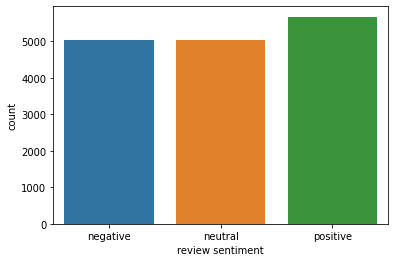

In [12]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
sentences = df.content.values
labels = df.sentiment.values

sent_lengths = []
for s in sentences:
    words = s.split(" ")
    sent_lengths.append(len(words))
print ("The maximum length of the input sentences - ",max(sent_lengths))

The maximum length of the input sentences -  391


In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.20, shuffle=True, stratify=df['sentiment'])

le = LabelEncoder()
y_train = np.asarray(le.fit_transform(train['sentiment']))
y_val = np.asarray(le.fit_transform(val['sentiment']))

In [16]:
import tqdm
# Initialise Bert Tokenizer
bert_tokenizer_transformer = BertTokenizer.from_pretrained('bert-base-cased')

def create_input_array(df, tokenizer):
    sentences = df.content.values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=512,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)

    return input_ids, attention_masks, token_type_ids

In [17]:
train_inputs = [create_input_array(train[:], tokenizer=tokenizer)]
val_inputs = [create_input_array(val[:], tokenizer=tokenizer)]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
def convert_inputs_to_tf_dataset(inputs,y):
    max_seq_len = 512
    ids = inputs[0][1]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, max_seq_len))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, max_seq_len))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, max_seq_len))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()

    return [ids, masks, token_types, y]

In [34]:
training_df = convert_inputs_to_tf_dataset(train_inputs[0], y_train[0])
type(train_inputs[0])

Input ids shape:  (1, 512)
Input Masks shape:  (1, 512)
Token type ids shape:  (1, 512)


tuple

In [41]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
max_seq_len = 768
n_classes = 3

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', trainable=True, num_labels=n_classes)

input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len, ), dtype=np.int32)
input_mask_layer = tf.keras.layers.Input(shape=(max_seq_len, ), dtype=np.int32)
input_token_type_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=np.int32)

bert_layer = model([input_ids_layer, input_mask_layer, input_token_type_layer])[0]
flat_layer = tf.keras.layers.Flatten()(bert_layer)
dropout= tf.keras.layers.Dropout(0.3)(flat_layer)
dense_output = tf.keras.layers.Dense(n_classes, activation='softmax')(dropout)

model_ = tf.keras.Model(inputs=[input_ids_layer, input_mask_layer, input_token_type_layer], outputs=dense_output)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
print (model.summary())
model.compile(optimizer='adam', loss=loss, metrics=[metric])


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_458 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
model.fit(train_inputs, y_train, epochs=1, batch_size = 32,verbose=1)

ValueError: ignored

In [ ]:
# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids = []
# attention_masks = []
# token_type_ids = []

# # For every sentence...
# for sent in sentences:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 512,           # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )
#     input_ids.append(encoded_dict['input_ids'])
#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks.append(encoded_dict['attention_mask'])
#     token_type_ids.append(encoded_dict['token_type_ids'])

# input_ids = tf.convert_to_tensor(input_ids)
# attention_masks = tf.convert_to_tensor(attention_masks)
# token_type_ids = tf.convert_to_tensor(token_type_ids)
# print ("Completed the pre-processing")

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print ("Train Size -", train_size)
print ("Test Size - ", val_size)

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)